### Project Desription:
#### Project goal is to build a Generative Adversarial Network (GAN) that generates 7000 to 10000 Monet style images.
#### Here is a link to the Kaggle competition https://www.kaggle.com/competitions/gan-getting-started.

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

#### Dataset:
1. monet_jpg - 300 Monet paintings sized 256x256 in JPEG format  

2. monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format  

3. photo_jpg - 7028 photos sized 256x256 in JPEG format  

4. photo_tfrec - 7028 photos sized 256x256 in TFRecord format  



#### Output Requirements:
A file images.zip that contains 7,000-10,000 images sized 256x256.

#### Import Standard Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

#### Import Keras Libraries

In [32]:
import keras
from keras import layers

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, Conv2D, Conv2DTranspose, UpSampling2D, Dropout, Activation, Concatenate
from tensorflow.keras.backend import clear_session
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tensorflow.keras import backend as K


#### Lets import the dataset into the notebook

In [3]:
import cv2
import os

os.getcwd()
os.chdir('C:\\Users\\sorab')

#### Function to Load Images

In [4]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images


Lets Load Paintings

In [5]:
folder = "ML2 Projects/Monet Paintings/monet_jpg"
paintings = load_images_from_folder(folder)
paintings = np.array(paintings)

Lets Load Pictures

In [6]:
folder2 = "ML2 Projects/Monet Paintings/photo_jpg"
photos = load_images_from_folder(folder2)
photos = np.array(photos)

#### Quick EDA on the dataset

In [7]:
print(paintings.shape)
print(photos.shape)

(300, 256, 256, 3)
(7038, 256, 256, 3)


##### Lets view the first 8 paintings and photos

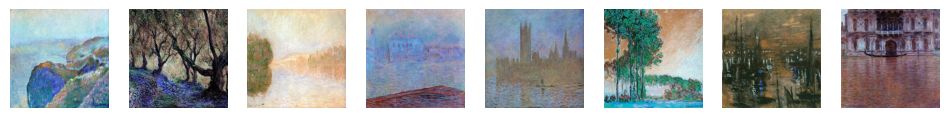

In [27]:
plt.figure(figsize=(12, 12))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(paintings[i])
    plt.axis('off')
plt.show()


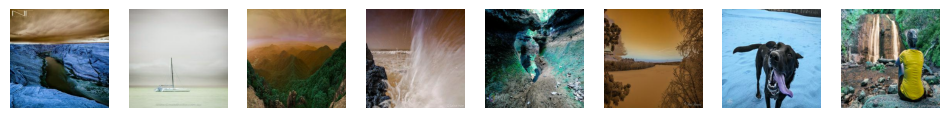

In [28]:
plt.figure(figsize=(12, 12))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(photos[i])
    plt.axis('off')
plt.show()


#### After doing some research decided to work with tensor flow prefetch dataset instead of numpy arrays.Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.


In [113]:
# Data Loading and Preprocessing
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = (image - 0.5) * 2  # Normalize to [-1, 1]
    return image

In [114]:
def generate_dataset(photo_path, painting_path, batch_size=1):
    photo_files = tf.data.Dataset.list_files(photo_path + '/*.jpg')
    painting_files = tf.data.Dataset.list_files(painting_path + '/*.jpg')

    photos = photo_files.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    paintings = monet_files.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = tf.data.Dataset.zip((photos, paintings))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [115]:
# Prepare Dataset
photo_path = 'ML2 Projects/Monet Paintings/photo_jpg'
monet_path = 'ML2 Projects/Monet Paintings/monet_jpg'
batch_size = 1
dataset = prepare_dataset(photo_path, monet_path, batch_size=batch_size)

#### Lets check the dataset

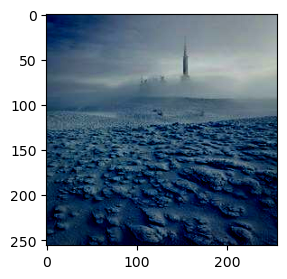

In [110]:
plt.figure(figsize=(3, 3))
plt.imshow(list(dataset)[0][0][0])

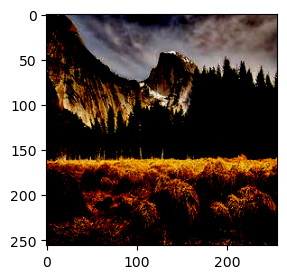

In [111]:
plt.figure(figsize=(3, 3))
plt.imshow(list(dataset)[1][0][0])

#### Model Architecture....Lets build a generator to generate images.A key element responsible for creating fresh, accurate data in a Generative Adversarial Network (GAN) is the generator model. The generator takes random noise as input and converts it into complex data samples, such text or images. It is commonly depicted as a deep neural network. We will use Convolutional layers to build our generator with leaky RELU as activation. In this basically we are taking the input image through 3 Convoluted layers and then Conv Transpose layers are deconvoluting the image to produce an output which would feed into the discriminator. The discriminator would then tell us if the image is fake or not.



In [56]:
def generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=1, padding='same', input_shape=[256, 256, 3]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(3, kernel_size=7, strides=1, padding='same', activation='tanh')
    ])
    return model

In [57]:
def discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=[256, 256, 3]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(256, kernel_size=4, strides=2, padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same')
    ])
    return model

### Loss Functions to perform gradient descent. For Discriminator we have binary cross entropy as loss (yi = real, yhat = fake). For generator the loss is also binary (discriminator calls the generated image as fake).

In [58]:
# Loss Functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return loss_obj(tf.ones_like(fake_output), fake_output)

#### Optimizers to run the model

In [59]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(.0001, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(.0001, beta_1=0.5)

#### Lets define the training steps and gradient descent....the first function defines how one step would look and the 2 nd function would basically loop over the entire dataset.

In [60]:
@tf.function
def train_step(real_photo, real_monet, monet_generator, photo_generator, monet_discriminator, photo_discriminator):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = monet_generator(real_photo, training=True)
        fake_photo = photo_generator(real_monet, training=True)

        real_monet_disc = monet_discriminator(real_monet, training=True)
        real_photo_disc = photo_discriminator(real_photo, training=True)

        fake_monet_disc = monet_discriminator(fake_monet, training=True)
        fake_photo_disc = photo_discriminator(fake_photo, training=True)

        gen_monet_loss = generator_loss(fake_monet_disc)
        gen_photo_loss = generator_loss(fake_photo_disc)

        disc_monet_loss = discriminator_loss(real_monet_disc, fake_monet_disc)
        disc_photo_loss = discriminator_loss(real_photo_disc, fake_photo_disc)

    # Update the generators and discriminators
    generator_grads = tape.gradient([gen_monet_loss, gen_photo_loss], monet_generator.trainable_variables + photo_generator.trainable_variables)
    discriminator_grads = tape.gradient([disc_monet_loss, disc_photo_loss], monet_discriminator.trainable_variables + photo_discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, monet_generator.trainable_variables + photo_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, monet_discriminator.trainable_variables + photo_discriminator.trainable_variables))

    return gen_monet_loss, gen_photo_loss, disc_monet_loss, disc_photo_loss

In [61]:
import matplotlib.pyplot as plt

# Training Loop
def train(dataset, epochs, monet_generator, photo_generator, monet_discriminator, photo_discriminator):
    # Lists to store losses for each epoch
    gen_monet_losses = []
    gen_photo_losses = []
    disc_monet_losses = []
    disc_photo_losses = []
    
    for epoch in range(epochs):
        # Initialize loss values for the epoch
        epoch_gen_monet_loss = 0
        epoch_gen_photo_loss = 0
        epoch_disc_monet_loss = 0
        epoch_disc_photo_loss = 0
        batch_count = 0
        
        for real_photo, real_monet in dataset:
            # Get the losses for this batch
            gen_monet_loss, gen_photo_loss, disc_monet_loss, disc_photo_loss = train_step(
                real_photo, real_monet, monet_generator, photo_generator, monet_discriminator, photo_discriminator
            )
            
            # Accumulate losses for this epoch
            epoch_gen_monet_loss += gen_monet_loss.numpy()
            epoch_gen_photo_loss += gen_photo_loss.numpy()
            epoch_disc_monet_loss += disc_monet_loss.numpy()
            epoch_disc_photo_loss += disc_photo_loss.numpy()
            batch_count += 1
        
        # Calculate average loss for the epoch
        gen_monet_losses.append(epoch_gen_monet_loss / batch_count)
        gen_photo_losses.append(epoch_gen_photo_loss / batch_count)
        disc_monet_losses.append(epoch_disc_monet_loss / batch_count)
        disc_photo_losses.append(epoch_disc_photo_loss / batch_count)
        
        # Print losses for the current epoch
        print(f'Epoch {epoch+1}, gen_monet_loss: {gen_monet_losses[-1]}, gen_photo_loss: {gen_photo_losses[-1]}, disc_monet_loss: {disc_monet_losses[-1]}, disc_photo_loss: {disc_photo_losses[-1]}')
    
    # Return the recorded losses
    return gen_monet_losses, gen_photo_losses, disc_monet_losses, disc_photo_losses

Lets now Initialize our models

In [62]:
# Initialize Models
monet_generator = generator()
photo_generator = generator()
monet_discriminator = discriminator()
photo_discriminator = discriminator()

C:\Users\sorab\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Lets fit the model....5 epochs due to the computing power at my disposal.

In [73]:
# Call training function and capture losses
gen_monet_losses, gen_photo_losses, disc_monet_losses, disc_photo_losses = train(
    dataset, epochs=5, monet_generator=monet_generator, photo_generator=photo_generator, 
    monet_discriminator=monet_discriminator, photo_discriminator=photo_discriminator
)

Epoch 1, gen_monet_loss: 0.7555049623052279, gen_photo_loss: 0.8299313791592916, disc_monet_loss: 1.3549699274698894, disc_photo_loss: 1.3097335335612297
Epoch 2, gen_monet_loss: 0.776019892046849, gen_photo_loss: 0.75219344774882, disc_monet_loss: 1.3518552339076997, disc_photo_loss: 1.363777498404185
Epoch 3, gen_monet_loss: 0.7628968437512715, gen_photo_loss: 0.75797592908144, disc_monet_loss: 1.3653012388944625, disc_photo_loss: 1.3626425164937972
Epoch 4, gen_monet_loss: 0.7890984879930815, gen_photo_loss: 0.7739385249217351, disc_monet_loss: 1.3323757002751033, disc_photo_loss: 1.3634867131710053
Epoch 5, gen_monet_loss: 0.8865323474506537, gen_photo_loss: 0.7774992381532987, disc_monet_loss: 1.2944437912106515, disc_photo_loss: 1.3561739512284596


#### lets now look at the generator and discriminator losses

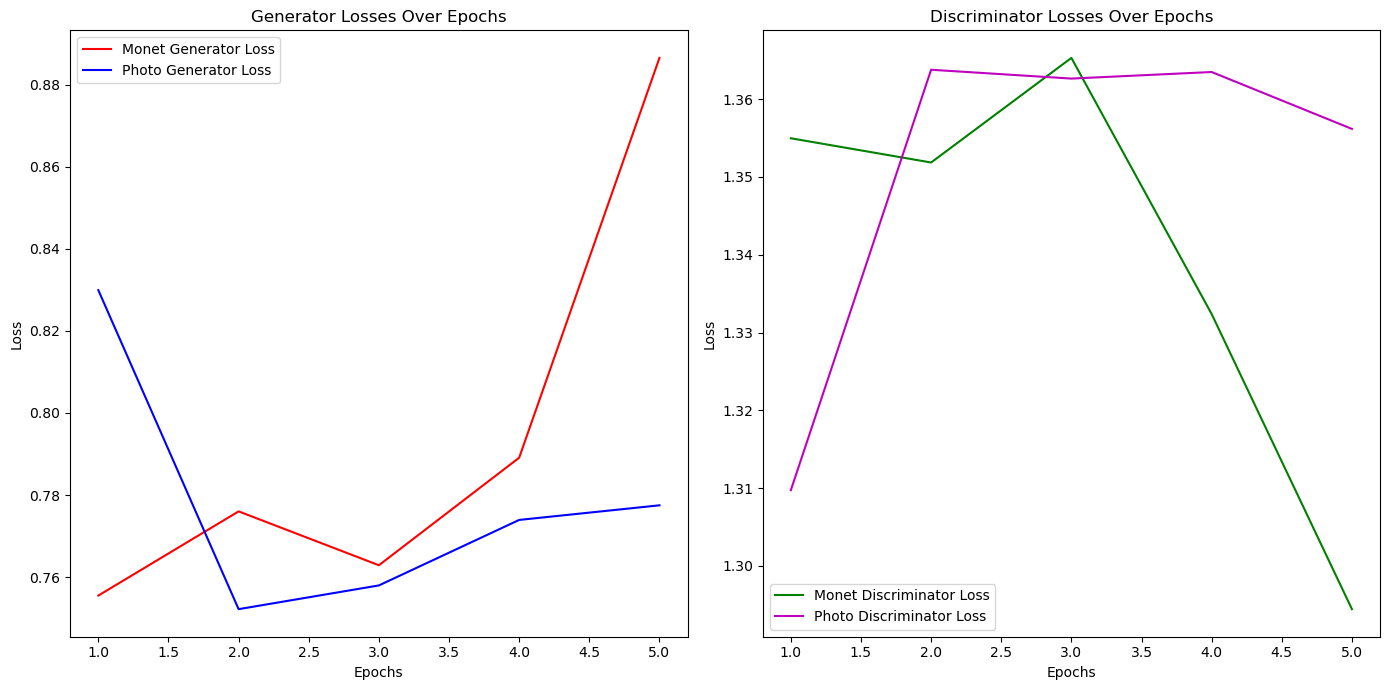

In [74]:
# Plotting function
def plot_losses(gen_monet_losses, gen_photo_losses, disc_monet_losses, disc_photo_losses):
    epochs = range(1, len(gen_monet_losses) + 1)
    
    plt.figure(figsize=(14, 7))
    
    # Plot generator losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, gen_monet_losses, 'r', label="Monet Generator Loss")
    plt.plot(epochs, gen_photo_losses, 'b', label="Photo Generator Loss")
    plt.title("Generator Losses Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot discriminator losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, disc_monet_losses, 'g', label="Monet Discriminator Loss")
    plt.plot(epochs, disc_photo_losses, 'm', label="Photo Discriminator Loss")
    plt.title("Discriminator Losses Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the plot function after training
plot_losses(gen_monet_losses, gen_photo_losses, disc_monet_losses, disc_photo_losses)

#### lets save the models so we can call them to generate fake Monet images

In [76]:
# Saving models
monet_generator.save("monet_generator.keras")
photo_generator.save("photo_generator.keras")
monet_discriminator.save("monet_discriminator.keras")
photo_discriminator.save("photo_discriminator.keras")

#### Saving the images generated to submit to Kaggle

In [78]:
import shutil
import os
import numpy as np
from PIL import Image
import tensorflow as tf

# Load the trained CycleGAN generator model
monet_generator = tf.keras.models.load_model('monet_generator.keras')

#photo_dataset = prepare_dataset(photo_ds_path, batch_size=32)

# Directory to save the generated Monet-style images (must be in '/kaggle/working/')
output_dir = 'ML2 Projects/Monet Paintings/monet_images'  # Ensure the path is in /kaggle/working/ for visibility
os.makedirs(output_dir, exist_ok=True)

# Generate and save Monet-style images
i = 1
for img_batch in final_dataset:
    # Generate Monet-style image using the trained generator
    generated_images = monet_generator(img_batch, training=False)
    generated_images = (generated_images * 0.5 + 0.5) * 255.0  # Rescale from [-1, 1] to [0, 255]
    generated_images = generated_images.numpy().astype(np.uint8)
    
    # Save each image in the batch
    for img in generated_images:
        im = Image.fromarray(img)
        im.save(f"{output_dir}/{i}.jpg")
        i += 1
    
    # Stop if 7,000 images have been generated (if you need to limit to a certain number)
    if i > 7000:
        break

# Create a submission file (e.g., a zip archive of all generated images)
shutil.make_archive("ML2 Projects/Monet Paintings/images", 'zip', output_dir)  # Save to /kaggle/working/

print("Submission file created: images.zip")

Submission file created: images.zip


#### Project Summary and Takeways
##### In this project we developed a GAN Model which probably was the most challenging part of the ML courses. The GAN took an input of real Monet paintings and images and produced fake Monet images. Kaggle is still running the file and I am hoping that I should have my submission score soon.